In [1]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()
pd.set_option("mode.copy_on_write", True)


# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions
import awkward as ak

CHAMBER_TO_INPUT_CAL = {
    "BMG": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0051.ntuple.root',
    "BIS7A02": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0113.ntuple.root',
    "BIS7A04": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0114.ntuple.root',
    "BIS7A06": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0115.ntuple.root',
    "BIS7A08": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0116.ntuple.root',
    "BIS7A10": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0117.ntuple.root',
    "BIS7A12": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0118.ntuple.root',
    "BIS7A14": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0119.ntuple.root'
}

OPERATING_CHAMBER = "BIS7A02"
inputCalibNtuple = CHAMBER_TO_INPUT_CAL[OPERATING_CHAMBER]
ACTIVE_TIME_WINDOW=1.3*(10**(-6))
ADC_CUT_VAL = 50
noise_thresh=20000

#tube_id gives the tube index


def tube_id(row, chamber):
    # Grab the tube name
    tube_name = row['rawMdt_tubeInfo']  # Assuming the column name that holds the tube name is 'rawMdt_tubeInfo'
    # Split the tube name once and unpack into components
    _, ml_index, ly_index, tube_no = tube_name.split('-')
    # Convert string indices to integers
    ml_index = int(ml_index)
    ly_index = int(ly_index)
    tube_no = int(tube_no)
    

    unique_tube_id = ((ml_index - 1) * chamberlist_run3.MDTnTml(chamber, 1) +
                      (ly_index - 1) * chamberlist_run3.MDTnTly(chamber, ml_index) +
                      tube_no)
    return unique_tube_id

#ADD TUBE_ID AND NIOSE RATE COLUMNS TO THE ORIGINAL DATFAFRAME

def noise_rate(df):
    df['Tube_ID']=df.apply(lambda row: tube_id(row, OPERATING_CHAMBER),axis=1)
    tube_hits = df['rawMdt_tubeInfo'].value_counts()
    df['Tube_hits']=df['rawMdt_tubeInfo'].map(tube_hits)
    df['Noise_rate']=df['Tube_hits']/(ACTIVE_TIME_WINDOW*total_evts)  #returns the original dataframe with added columns of noise rate and tube id

    return df

#Extract list of noisy_tubes and dataframe removing noisy_tubes

def noisy_tubes(df):
    # fruits_above_threshold = df[df['Price'] > price_threshold]['Fruit']
    n_tubes=df[df['Noise_rate']>noise_thresh]['rawMdt_tubeInfo']
    # noise_thresh
    n_tb_list=n_tubes.unique().tolist()
    return n_tb_list

#INTRODUCE ADC CUT

def adc_cut(df,cut):  #returns complete dataframe just introducing adc_cut(doesn't give any info on noise_rate etc)
    df_adc=df[df['rawMdt_adc']>cut]
    return df_adc


#PLOTS A HISTOGRAM FOR ALL VALUES OF ADC FOR A SINGLE TUBE
    
def adc_spectrum(df):

    fig,ax = plt.subplots(figsize=(8,6))
       
    # ADC count without cut
    mdt_adc = df.avg_adc.values.astype(float)
    min_adc = 50
    max_adc = 350
    
    xadc, xbins, patch = ax.hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc spectrum for a single tube')
    ax.set_xlabel('adc values')
    return 

#ADDS A COLUMN WITH MEAN ADC VALUES TO DF WITH ADC CUT
def calculate_avg_adc(df):
    df['Avg_adc']=df.groupby('rawMdt_tubeInfo')['rawMdt_adc'].transform('mean') #groups data wrt tubeinfo uniue values ie tube names and transform 
                                          # calculates avg values of the adc column are projects the values back to respective columns.
    return df


#RETURNS A DATAFRAME EXCLUDING ALL THE NOISY TUBES
def df_filtered(df):         
    # df_raw_adc_cut=adc_cut(df,cut)  #Complete dataframe after introducing adc_cut

    df_raw_chamber_noisy_filtered=df[~df['rawMdt_tubeInfo'].isin(noisy_tubes_list)]
    return df_raw_chamber_noisy_filtered

#RETURNS A DATAFRAME OF ALL THE NOISY TUBES
def df_raw_noisy(df,cut):         
    df_raw_adc_cut=adc_cut(df,cut)  #Complete dataframe after introducing adc_cut

    df_raw_noise=df_raw_adc_cut[df_raw_adc_cut['rawMdt_tubeInfo'].isin(noisy_tubes_list)]
    return df_raw_noise

#Noise_Rate v/s Tube_Id Plot
def plot_for_noise_rate(df, chamber, cut,noise_thresh):
    run='456729'
    fig,axes = plt.subplots(figsize=(28, 32), nrows = 3, ncols = 1)  
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
    alpha_value = 1  #Transparency
    
    # df_noise_rate=noise_rate(df_raw_chamber,OPERATING_CHAMBER)
    df_noise_rate_sorted=df_noise_rate.sort_values(by='Tube_ID', ascending=True)
    
    axes[0].bar(df_noise_rate_sorted['Tube_ID'].astype(str), df_noise_rate_sorted['Noise_Rate'], color='skyblue')
    axes[0].set_title('Noise Rate without adc cut')
    axes[0].set_xlabel('Tube ID')
    axes[0].set_ylabel('Noise Rate')
    axes[0].set_xticks(np.arange(0, len(df_noise_rate_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut
    df_raw_chamber_with_adc_cut=adc_cut(df_raw_chamber,chamber,cut)
    df_noise_rate_with_adc_cut = noise_rate(df_raw_chamber_with_adc_cut,OPERATING_CHAMBER)
    df_noise_rate_with_adc_cut_sorted = df_noise_rate_with_adc_cut.sort_values(by='Tube_ID', ascending=True) 


    axes[1].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[1].set_title('Noise Rate with adc cut before removing noisy tubes')
    axes[1].set_xlabel('Tube ID')
    axes[1].set_ylabel('Noise Rate')
    axes[1].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut and noisy tubes removed
    df_raw_filtered=df_filtered(df_raw_chamber,chamber,cut,noise_thresh)
    df_noise_rate_removed=noise_rate(df_raw_filtered,chamber)
    df_noise_rate_removed_sorted=df_noise_rate_removed.sort_values(by='Tube_ID', ascending=True) 
    
    axes[2].bar(df_noise_rate_removed_sorted['Tube_ID'].astype(str), df_noise_rate_removed_sorted['Noise_Rate'], color='skyblue')
    axes[2].set_title('Noise Rate with adc cut after removing noisy tubes')
    axes[2].set_xlabel('Tube ID')
    axes[2].set_ylabel('Noise Rate')
    axes[2].set_xticks(np.arange(0, len(df_noise_rate_removed_sorted['Tube_ID'])+1, 50))
    # fig.savefig('Noise_rate for %s'%(chamber))
    plt.show()

# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber,plot_title):
    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    ax.set_title(plot_title)
    
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    # fig.savefig('Hitmap for %s'%(chamber))

# raw ADC and TDC hits plot with ADC cut at 50
def RawMdtplots(df,chamber,title):

    fig,axes = plt.subplots(figsize=(8, 3), nrows = 1, ncols = 2)
    # fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.4, hspace = 0.4)
    # fig.set_title(title, fontsize=20)
       
    # ADC count without cut
    mdt_adc = df.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0].set_xlim(min_adc,max_adc)
    axes[0].set_xlabel('adcCount',fontsize=15)
    axes[0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0].grid()
    axes[0].set_title(f'{chamber,title}_rawADC')
    
    
    # # raw TDC spectrum
    mdt_tdc = df.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1].set_xlim(min_tdc,max_tdc)
    axes[1].set_xlabel('tdcCount',fontsize=15)
    axes[1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1].grid()
    axes[1].set_title(f'{chamber,title}_rawTDC')
    
    fig.patch.set_facecolor('white')
    fig.savefig('Adc_Tdc for %s'%(chamber))
    plt.show()

def findAdcAfterFirstSpike():
    # Function that will show us where spikes at the start of adc counts end
    adc_cut_counts_sorted = df_raw_chamber_filtered['rawMdt_adc'].value_counts().sort_index()
    
    found_peak = False
    prev_count = None
    prev_adc = None
    found_increase = False
    for adc_cut, count in adc_cut_counts_sorted.items():
        print("Current adc_cut: " + str(adc_cut) + ", current count: " + str(count))
        if prev_count != None:
            if found_peak == False:
                # check for the peak
                if count < prev_count:
                    found_peak = True
            else:
                if count > prev_count and found_increase == False:
                    print("Found when count began increasing. Adc: " + str(prev_adc) + ", count: " + str(prev_count))
                    found_increase = True
        if adc_cut >= 100:
            break
        prev_count = count
        prev_adc = adc_cut

f=uproot.open(inputCalibNtuple)  

tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
        
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

process run 045672 lumiblock 0000_0004 region 113, chamberList ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02']


In [2]:
df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))  #converted awkward array to dataframe df_raw

# # expand all raw and trk hits with correct chamberName and tubeInfo
# df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
# df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
# df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])

df_raw

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 37   4299.335449   1780.843018   6481.250000   
      1                 37   4299.335449   1780.843018   6345.350098   
      2                 34   4299.335449   1780.843018   6330.250000   
      3                 36   4299.335449   1780.843018   6315.149902   
      4                 34   4299.335449   1780.843018   6300.049805   
...                    ...           ...           ...           ...   
33192 119               98   9174.689453   3800.280762  21714.507812   
      120               34   8855.579102   3668.101074  21688.496094   
      121              118  11328.250977   4692.314941  21688.496094   
      122              136  11300.501953   4680.821289  21688.496094   
      123               34  11272.752930   4669.327148  21688.496094   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc  
entry subentry                                       
0     0          24649649           118         197  
      1          24649640           118         197  
      2          24649639           118         185  
      3          24649638           118          78  
      4          24649637           118          71  
...                   ...           ...         ...  
33192 119       375921809           124         221  
      120       375921670           124        1020  
      121       376445998           124          86  
      122       376445997           124         111  
      123       376445996           124         142  

[3876947 rows x 7 columns]

In [47]:
# df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))  #converted awkward array to dataframe df_raw

# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])

# Creates new dataframe that only contains data for current chamber
DF_OP_CHAMBER = df_raw[df_raw['rawMdt_station']==OPERATING_CHAMBER]

df_all = tree.arrays() #gives total numner of events and not hits
total_evts=len(df_all)

print(f'Total Event in this file is {total_evts}')
DF_OP_CHAMBER.head()

Total Event in this file is 33193


rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 37   4299.335449   1780.843018   6481.250000   
      1                 37   4299.335449   1780.843018   6345.350098   
      2                 34   4299.335449   1780.843018   6330.250000   
      3                 36   4299.335449   1780.843018   6315.149902   
      4                 34   4299.335449   1780.843018   6300.049805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649649           118         197  BIS7A02-2-4-50   
      1          24649640           118         197  BIS7A02-2-4-41   
      2          24649639           118         185  BIS7A02-2-4-40   
      3          24649638           118          78  BIS7A02-2-4-39   
      4          24649637           118          71  BIS7A02-2-4-38   

               rawMdt_station rawMdt_type  
entry subentry                             
0     0               BIS7A02         BIS  
      1               BIS7A02         BIS  
      2               BIS7A02         BIS  
      3               BIS7A02         BIS  
      4               BIS7A02         BIS

In [46]:
# returns the original dataframe with added columns of noise rate and tube id

df_with_noise_rate=noise_rate(DF_OP_CHAMBER)  

#CREATES DATAFRAME WITH ADC CUT

df_with_adc_cut=adc_cut(DF_OP_CHAMBER_UPDATED,ADC_CUT_VAL)

#CREATES DF ONLY FOR NOISY TUBES

df_with_nt=df_raw_noisy(df_raw_updated_with_adc_cut,ADC_CUT_VAL)

#CREATES FILTERED DATAFRAME AFTER ADC CUT AND BY REMOVING NOISY TUBES

df_with_nt_removed=df_filtered(df_raw_updated_with_adc_cut) #creates df after introducing adc cut and removing noisy tubes

df_with_noise_rate.head()

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 37   4299.335449   1780.843018   6481.250000   
      1                 37   4299.335449   1780.843018   6345.350098   
      2                 34   4299.335449   1780.843018   6330.250000   
      3                 36   4299.335449   1780.843018   6315.149902   
      4                 34   4299.335449   1780.843018   6300.049805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649649           118         197  BIS7A02-2-4-50   
      1          24649640           118         197  BIS7A02-2-4-41   
      2          24649639           118         185  BIS7A02-2-4-40   
      3          24649638           118          78  BIS7A02-2-4-39   
      4          24649637           118          71  BIS7A02-2-4-38   

               rawMdt_station rawMdt_type  Tube_ID  Tube_hits     Noise_rate  \
entry subentry                                                                 
0     0               BIS7A02         BIS      686       2312   53579.415493   
      1               BIS7A02         BIS      677       6955  161178.561745   
      2               BIS7A02         BIS      676      10005  231860.749138   
      3               BIS7A02         BIS      675      13660  316563.501572   
      4               BIS7A02         BIS      674       9691  224583.960010   

                  avg_adc    Avg_adc  
entry subentry                        
0     0         50.253028  50.253028  
      1         39.867146  39.867146  
      2         37.975612  37.975612  
      3         48.357980  48.357980  
      4         40.116397  40.116397

In [6]:
# Prints list of noisy tubes
noisy_tubes_list=noisy_tubes(DF_OP_CHAMBER_UPDATED)
len(noisy_tubes_list)  #returns

71

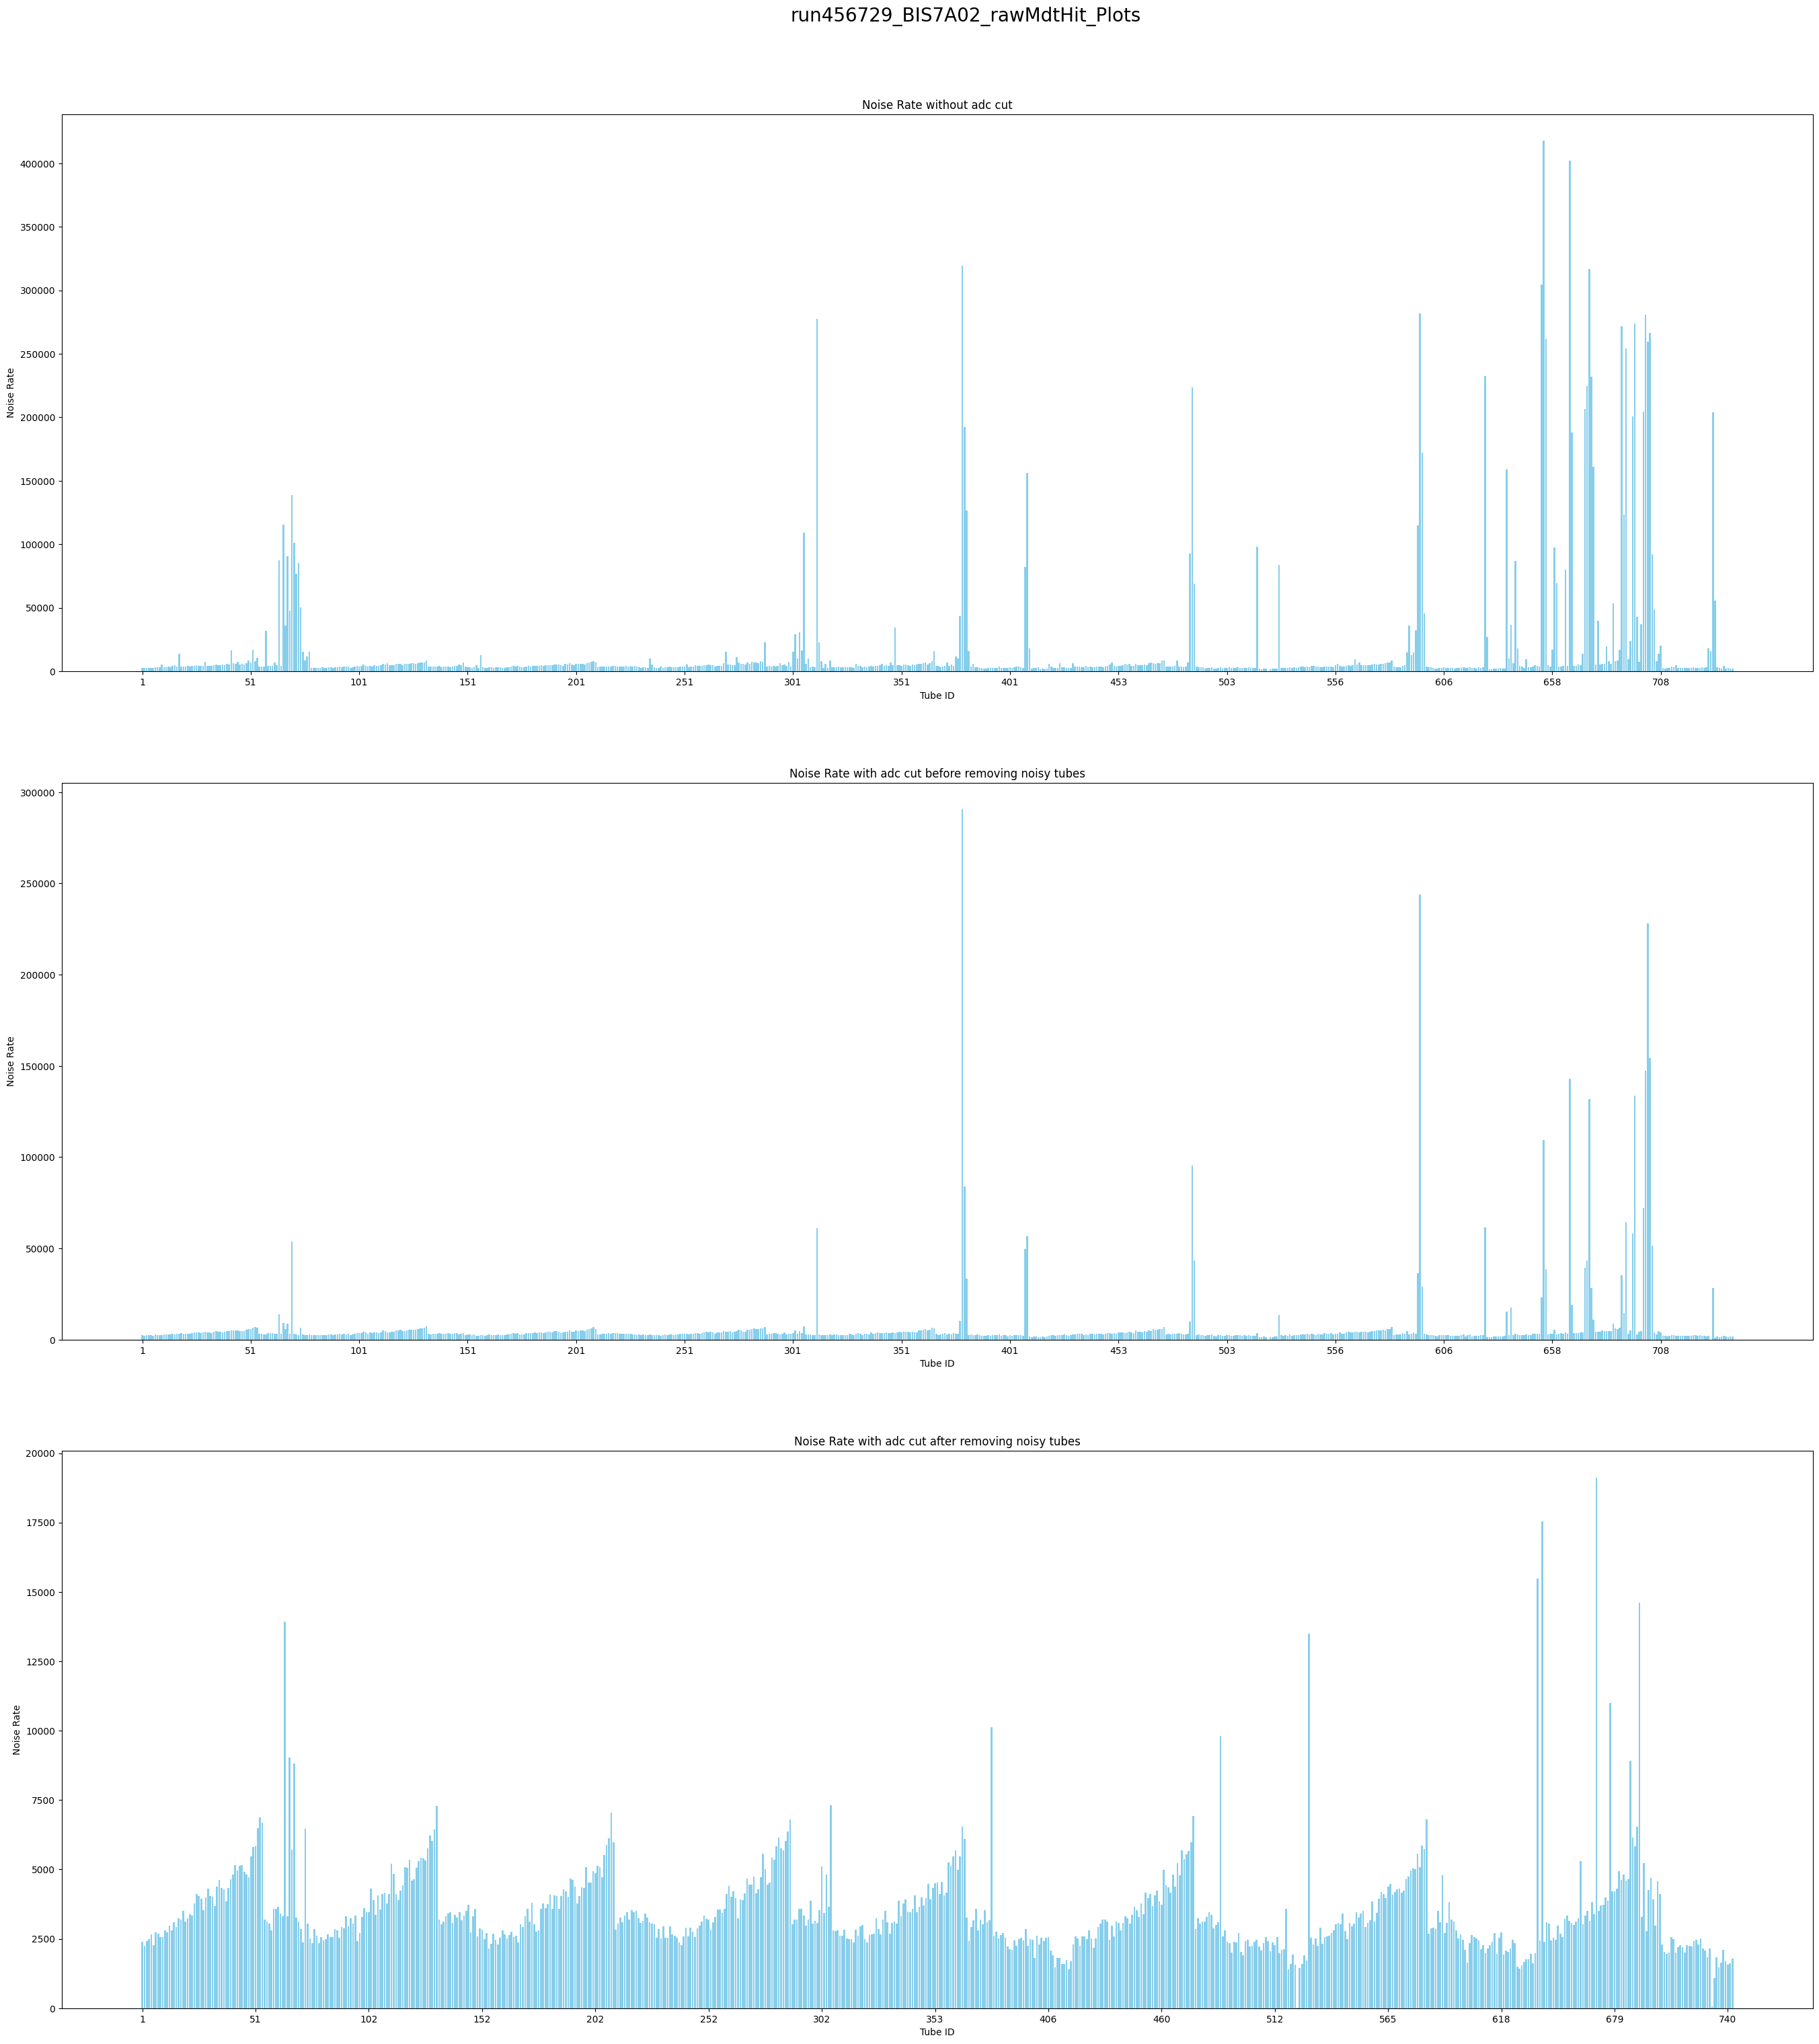

In [6]:
# Plots noise rate of each tube ID
plot_for_noise_rate(DF_OP_CHAMBER,OPERATING_CHAMBER,ADC_CUT_VAL,noise_thresh)

# Trials

# Hitmap plots

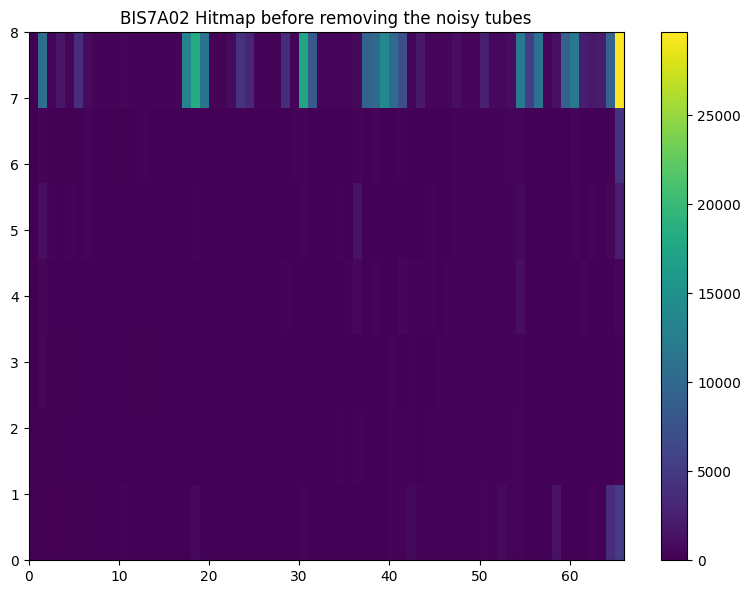

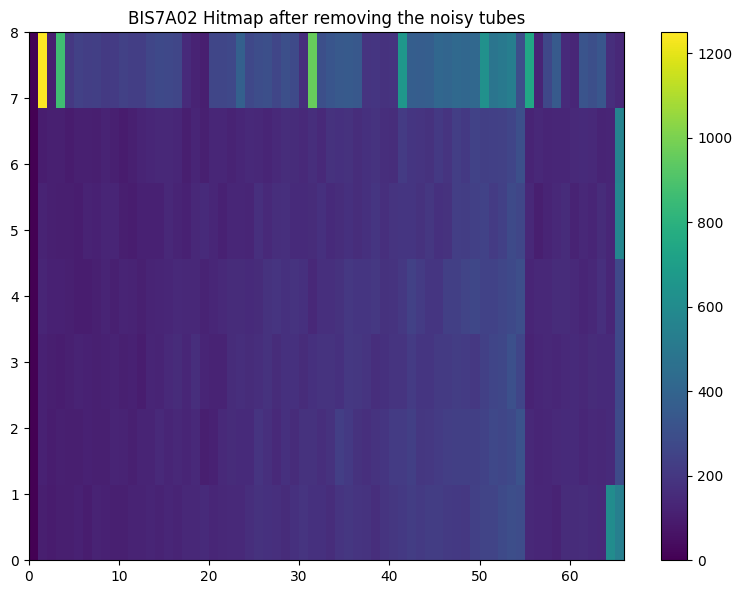

In [7]:
#HitMap Plots for both filtered and non-filtered
plotHitMap(DF_OP_CHAMBER,OPERATING_CHAMBER,f"{OPERATING_CHAMBER} Hitmap before removing the noisy tubes")

#Extracts filtered dataset for assigned chamber
df_raw_chamber_filtered = df_filtered(DF_OP_CHAMBER,OPERATING_CHAMBER,ADC_CUT_VAL,noise_thresh)

plotHitMap(df_raw_chamber_filtered,OPERATING_CHAMBER,f"{OPERATING_CHAMBER} Hitmap after removing the noisy tubes") #filtered

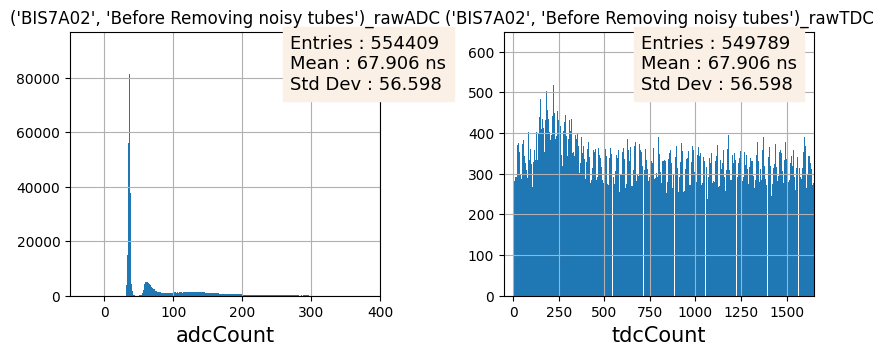

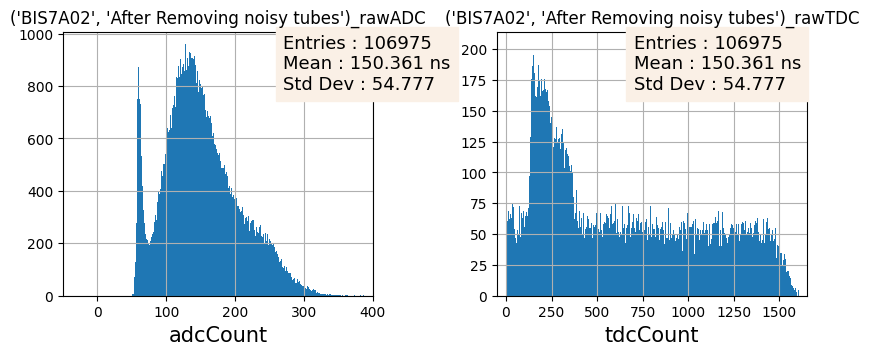

In [8]:
# plotRawMdtHits(df_raw,OPERATING_CHAMBER)
RawMdtplots(DF_OP_CHAMBER,OPERATING_CHAMBER,'Before Removing noisy tubes')  #crude plot
RawMdtplots(df_raw_chamber_filtered,OPERATING_CHAMBER,'After Removing noisy tubes') #filtered plot

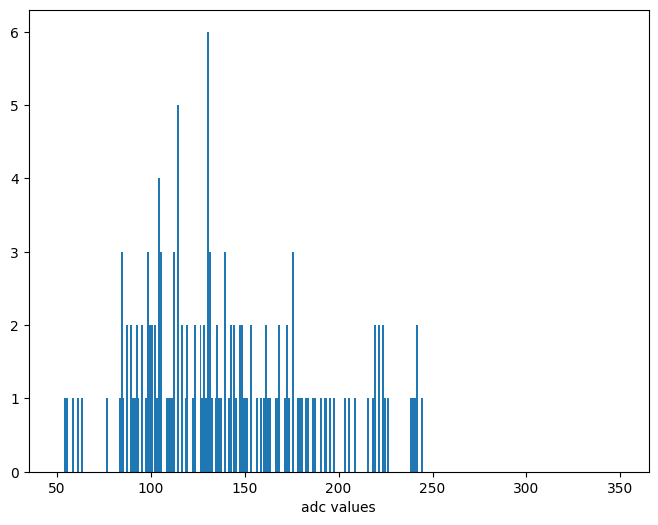

In [17]:
#Plotting avg_adc spectrum for noisy tube
df_noise_rate_sorted=df_noise_rate.sort_values(by=['Noise_Rate'], ascending=False)
 #extracted the tube_id of noisy_tube = 654

#create a dataframe that accounts in the adc cut
df_adc_cut=adc_cut(DF_OP_CHAMBER,ADC_CUT_VAL)

#Extract the dataframe for that parocular tube_id
df_noisiest_tube=df_adc_cut[df_adc_cut['rawMdt_tubeInfo']=='BIS7A02-2-4-18']
df_non_noisy_tube=df_adc_cut[df_adc_cut['rawMdt_tubeInfo']=='BIS7A02-1-4-69']
# df_12=DF_OP_CHAMBER[df_adc_cut['rawMdt_tubeInfo']=='BIS7A02-2-4-46']


# adc_spectrum(df_noisiest_tube)
adc_spectrum(df_non_noisy_tube)  


In [42]:
#UPDATES ORIGINAL DF BY CREATING AVG_ADC COLUMN
# DF_OP_CHAMBER_UPDATED['avg_adc']=DF_OP_CHAMBER_UPDATED.groupby('rawMdt_tubeInfo')['rawMdt_adc'].transform('mean')
df_op_chamber_updated_with_mean_adc=calculate_avg_adc(df_raw_updated_with_adc_cut)
df_raw_nt_updated=calculate_avg_adc(df_raw_nt)
# df_op_chamber_updated_with_mean_adc['rawMdt_adc'].unique()

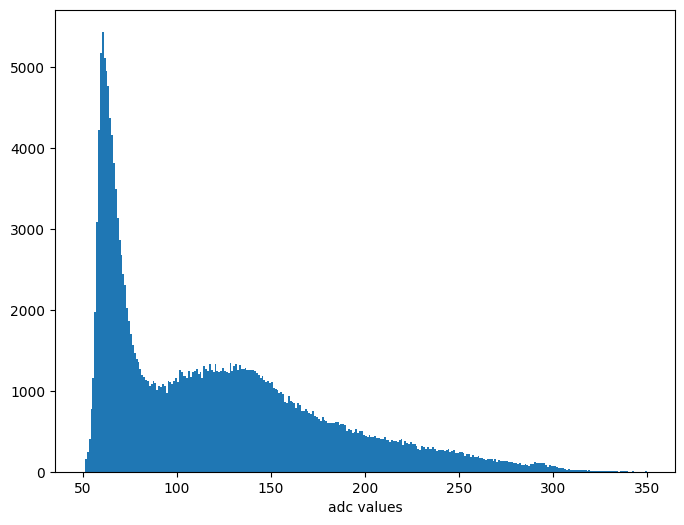

In [37]:
adc_spectrum(df_op_chamber_updated_with_mean_adc) # for all the tubes

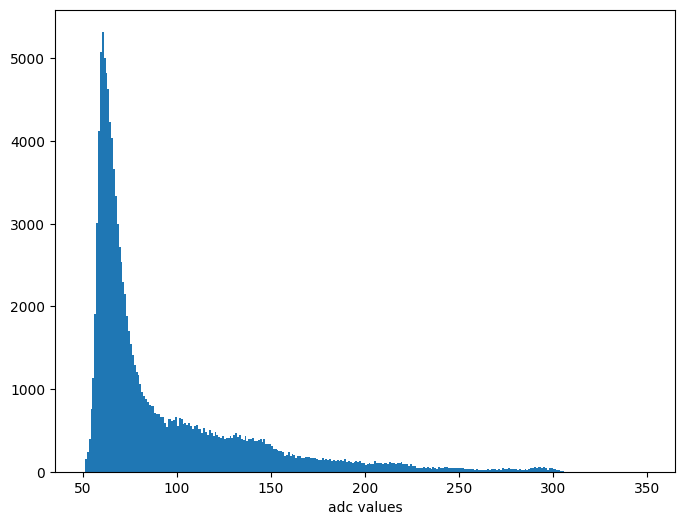

In [38]:
adc_spectrum(df_raw_nt_updated) #for the noisy tubes

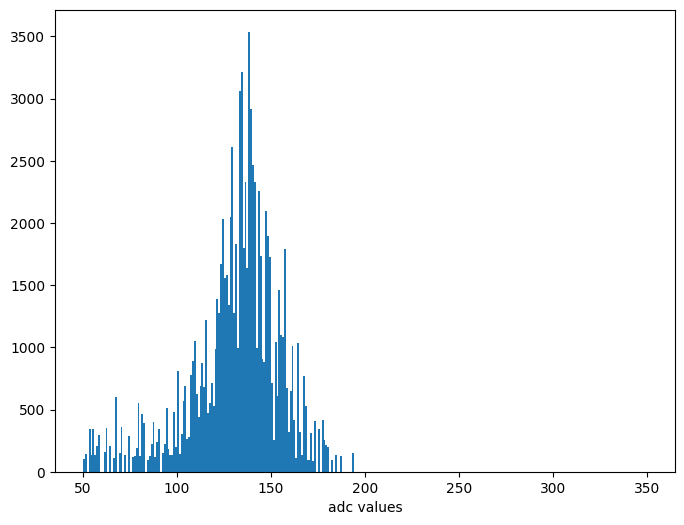

In [45]:
adc_spectrum(df_raw_nt_removed)

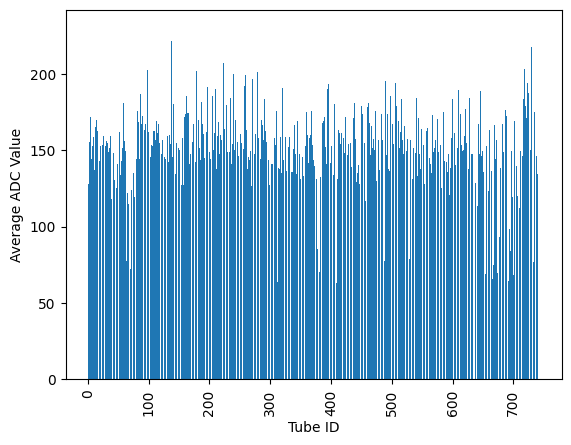

In [33]:
plt.bar(df_op_chamber_updated_with_mean_adc['Tube_ID'],df_op_chamber_updated_with_mean_adc['Avg_adc'])
plt.xlabel('Tube ID')
plt.ylabel('Average ADC Value')
plt.xticks(rotation=90)
plt.show()

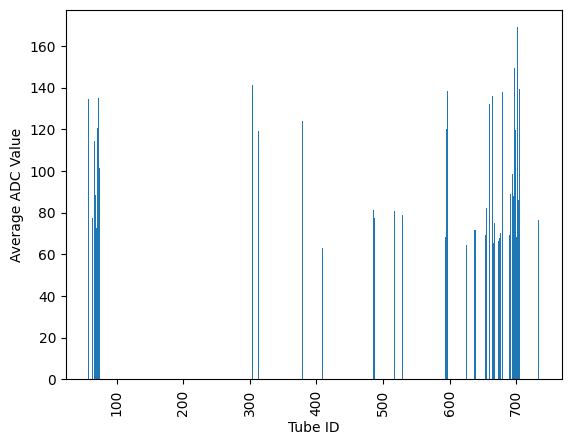

In [36]:
plt.bar(df_raw_nt_updated['Tube_ID'],df_raw_nt_updated['Avg_adc'])
plt.xlabel('Tube ID')
plt.ylabel('Average ADC Value')
plt.xticks(rotation=90)
plt.show()


In [22]:
def avg_adc_plot(df):
    
    fig,ax=plt.subplots()
    ax.bar(df['rawMdt_tubeInfo'], df['Avg_adc'])
   
    ax.set_xlabel('Tube name')
    ax.set_ylabel('Mean adc value')
    plt.xticks(rotation=90)
    plt.show()
avg_adc_plot(df_op_chamber_updated_with_mean_adc)
# avg_adc_plot(df_raw_nt_removed)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x36b3fe2a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# CALCULATES AVG_ADC FOR ALL TUBES


# df_noisy_tubes=noisy_tubes(DF_OP_CHAMBER,OPERATING_CHAMBER,ADC_CUT_VAL,noise_thresh)
# df_with_mean_adc_all_tubes=calculate_avg_adc(df_adc_cut)  #this dataframe has additional column with mwan adc values for each tube
# df_with_mean_adc_noisy_tubes=calculate_avg_adc(df_noisy_tubes)
# (scatter/bar)plot avg adc vs tube name
# plt.bar(df_with_mean_adc['rawMdt_tubeInfo'],df_with_mean_adc['Avg_adc'])
# plt.show()

# def avg_adc_plot(df):
#     ax=plt.bar(df['rawMdt_tubeInfo'],df['Avg_adc'])
#     ax.yet_xlabel('Tube name')
#     ax.set_ylabel('Mean adc value')
#     ax.xticks(rotation=90)
#     plt.show()
# avg_adc_plot(df_with_mean_adc_all_tubes)
# avg_adc_plot(df_with_mean_adc_noisy_tubes)

# df_noisy_tubes
# def calculate_avg_adc(df,tube):
#     df_adc_tube=df[df['rawMdt_tubeInfo']==str(tube)] #extracted dataframe for a single tube
#     avg_value=df_adc_tube['rawMdt_adc'].mean() #calculates the average of all the adc values of that tube
#     return avg_value
# avg_adc(DF_OP_CHAMBER,'BIS7A02-1-2-22')

# ag=[]
# for i in range(len(df_noise_rate['Tube_Name'])):
#     average = calculate_avg_adc(DF_OP_CHAMBER, df_noise_rate['Tube_Name'][i])
#     ag.append(average)
# print
# (ag)
# plt.bar(noisy_tubes_list,ag)

# # Optionally, you can label the axes
# plt.xlabel('Tube ID')
# plt.ylabel('Average ADC Value')
# plt.xticks(rotation=90)
# # Show the plot
# plt.show()
